In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

tf.__version__

'2.8.0'

In [2]:
vram = 14 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])
print(len(gpus), "Physical GPUs Configured")

tf.random.set_seed(42)

1 Physical GPUs Configured


In [3]:
def load_n_images(count=1000,image_dir='images/',image_size=256):
    image_array = []
    for image_file in os.listdir(image_dir):
        if len(image_array) >= count:
            break
        else:
            image = cv2.imread(image_dir+image_file)
            image = cv2.resize(image,(image_size,image_size))
            image_array.append(image)
    return np.array(image_array)

In [4]:
def preprocess_images(image_set,test_fraction=0.05):
    l_array = []
    lab_array = []

    for image in image_set:
        lab_image = cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        l_channel = l_channel/255
        a_channel = (a_channel-128)/255
        b_channel = (b_channel-128)/255
        recombined = np.dstack((a_channel,b_channel))

        l_array.append(np.expand_dims(l_channel,axis=2))
        lab_array.append(recombined)

    return train_test_split(np.array(l_array), np.array(lab_array),test_size=test_fraction,random_state=42)

In [5]:
def X_and_y_to_rgb(gray,colors):
    a_channel = colors [:,:,0]
    b_channel = colors [:,:,1]
    l_channel = gray * 255
    a_channel = (a_channel*255)+128
    b_channel = (b_channel*255)+128
    recombined = np.dstack((l_channel,a_channel,b_channel))
    converted = cv2.cvtColor(recombined.astype(np.uint8),cv2.COLOR_LAB2RGB)
    return converted

In [6]:
def make_generator(image_size=256):

    inputs = layers.Input(shape=(image_size,image_size,1))

    down1 = layers.Conv2D(32,kernel_size=(5,5),padding='same')(inputs)
    down1 = layers.BatchNormalization()(down1)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(64,kernel_size=(5,5),padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(128,kernel_size=(7,7),padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    bottleneck = layers.Conv2D(256,kernel_size=(7,7),padding='same',activation='tanh')(down3)
    bottleneck = layers.BatchNormalization()(bottleneck)

    up3 = layers.Concatenate()([bottleneck,down3])
    up3 = layers.Conv2DTranspose(128,kernel_size=(7,7),padding='same')(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.LeakyReLU()(up3)

    up2 = layers.Concatenate()([up3,down2])
    up2 = layers.Conv2DTranspose(32,kernel_size=(5,5),padding='same')(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.LeakyReLU()(up2)

    up1 = layers.Concatenate()([up2,down1])
    up1 = layers.Conv2DTranspose(32,kernel_size=(5,5),padding='same')(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.LeakyReLU()(up1)

    outputs = layers.Conv2DTranspose(2,kernel_size=(5,5),padding='same',activation='relu')(up1)

    model = keras.models.Model(inputs,outputs)
    return model


In [7]:
def make_discriminator(image_size=256):

    model = keras.Sequential()

    model.add(layers.Conv2D(16,kernel_size=(5,5),padding='same',input_shape=(image_size,image_size,2)))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(32,kernel_size=(5,5),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(64,kernel_size=(5,5),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D())

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [8]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = losses.BinaryCrossentropy()
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss   
    return total_loss

def generator_loss(fake_output):
    cross_entropy = losses.BinaryCrossentropy()
    disc_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    return disc_loss

In [9]:
@tf.function
def gen_step(gray_batch):

    with tf.GradientTape() as gen_tape:
        generated_batch = generator(gray_batch,training=True)
        generated_disc_output = discriminator(generated_batch,training=False)
        gen_loss = generator_loss(generated_disc_output)
      
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

    gen_loss_tracker(gen_loss)

In [10]:
@tf.function
def disc_step(gray_batch,color_batch):
    
    with tf.GradientTape() as disc_tape:
        generated_batch = generator(gray_batch,training=False)
        generated_disc_output = discriminator(generated_batch,training=True)
        real_disc_output = discriminator(color_batch,training=True)
        disc_loss = discriminator_loss(real_disc_output,generated_disc_output)
    
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    disc_loss_tracker(disc_loss)

In [11]:
def train_model(epochs,dataset,save=False):
    
    for epoch in tqdm(range(epochs)):

        for gray_batch,color_batch in dataset:
            disc_step(gray_batch,color_batch)

        with disc_summary_writer.as_default():
            tf.summary.scalar('disc_loss',disc_loss_tracker.result(),step=epoch)

        for gray_batch,color_batch in dataset:
            gen_step(gray_batch)

        with gen_summary_writer.as_default():
            tf.summary.scalar('gen_loss',gen_loss_tracker.result(),step=epoch)

        if save:
            if not (epoch+1) % 10:
                generator.save(f'models/generator{epoch+1}.hdf5')
                discriminator.save(f'models/discriminator{epoch+1}.hdf5')

        disc_loss_tracker.reset_states()
        gen_loss_tracker.reset_states()

In [12]:
def show_test_images(X,y,count=5):

    y_pred = generator(X[:count]).numpy()

    fig,ax = plt.subplots(count,3,figsize=(12,4*count))
    for idx,row in enumerate(ax):
        
        row[0].imshow(X[idx],cmap='gray')
        row[1].imshow(X_and_y_to_rgb(X[idx],y_pred[idx]))
        row[2].imshow(X_and_y_to_rgb(X[idx],y[idx]))

        for axis in row:
            axis.set_xticks([])
            axis.set_yticks([])
    fig.set_facecolor('#FFFFFF')
    ax[0][0].set_title('Input',fontsize=32);
    ax[0][1].set_title('Colorized',fontsize=32);
    ax[0][2].set_title('True',fontsize=32);
    return fig

In [13]:
generator = make_generator(image_size=64)
generator_optimizer = optimizers.Adam(0.0005)
gen_loss_tracker = metrics.Mean('gen_loss',dtype=tf.float32)
gen_dir = 'logs/generator'
gen_summary_writer = tf.summary.create_file_writer(gen_dir)

discriminator = make_discriminator(image_size=64)
discriminator_optimizer = optimizers.Adam(0.0005)
disc_loss_tracker = metrics.Mean('disc_loss',dtype=tf.float32)
disc_dir = 'logs/discriminator'
disc_summary_writer = tf.summary.create_file_writer(disc_dir)

In [14]:
#tf.keras.utils.plot_model(generator,dpi=60,show_shapes=True)

In [15]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   832         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

In [16]:
#tf.keras.utils.plot_model(discriminator,dpi=60)

In [17]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        816       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        12832     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

In [18]:
images = load_n_images(20000,image_size=64)
X_train, X_test, y_train, y_test = preprocess_images(images,test_fraction=0.01)
dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)

In [21]:
train_model(50,dataset=dataset,save=False)

100%|████████████████████████████████████████| 50/50 [2:27:50<00:00, 177.41s/it]


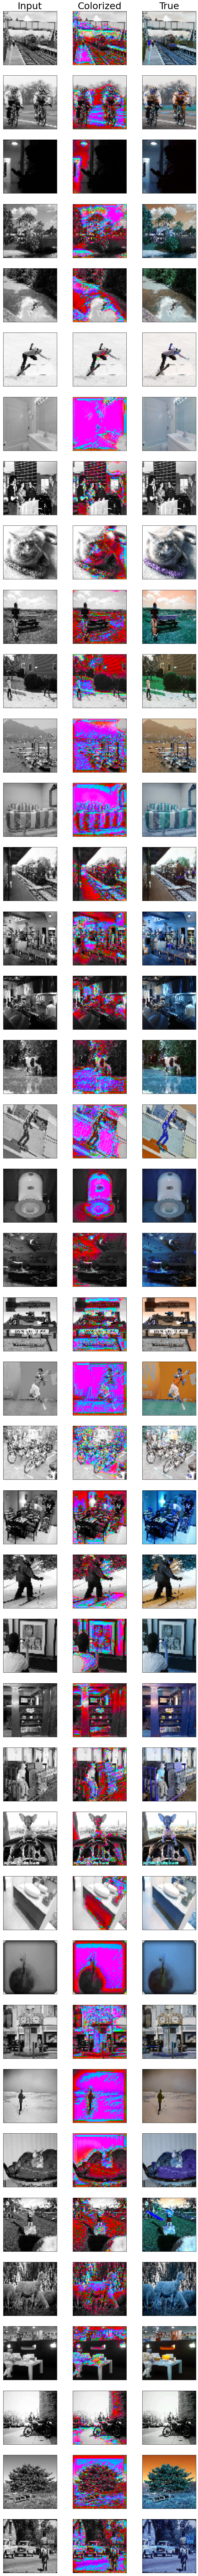

In [23]:
show_test_images(X_test,y_test,40);